In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'petroff10', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [6]:
# plt.style.use('seaborn-v0_8-muted')
plt.style.use('ggplot')
plt.style.use('seaborn-v0_8-ticks')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']  


In [7]:
# Import dataset
data = pd.read_csv('all_semeval_parids-labels.csv')

# Class distributions

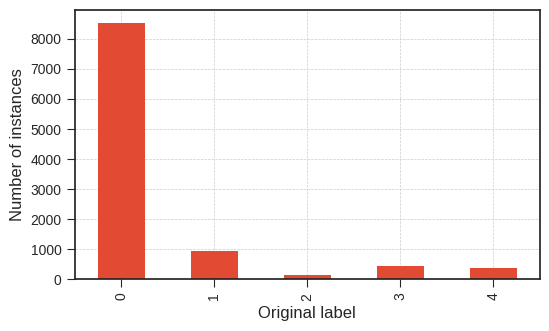

In [8]:
# Plot the distribution of orig_label, with the x-axis values in ascending order
plt.figure(figsize=(6, 3.5))
orig_label_counts = data['orig_label'].value_counts()

orig_label_counts.sort_index().plot(kind='bar')
plt.ylabel('Number of instances')
plt.xlabel('Original label')

# Grid
plt.grid(True, which='major', linestyle='--', linewidth=0.5)


# Text Lengths

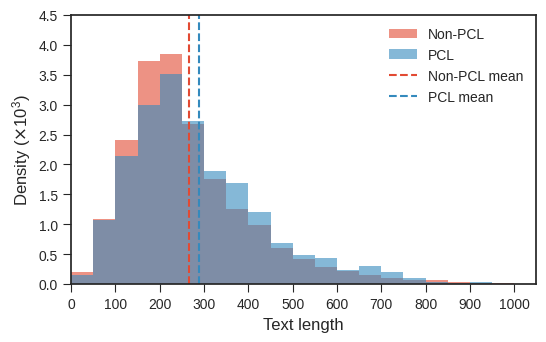

In [9]:
# Get the text lengths for each class
pcl_lengths = data[data['label'] == 1]['text'].str.len()
non_pcl_lengths = data[data['label'] == 0]['text'].str.len()

# Last bin captures all 1000+
bin_edges = [i for i in range(0, 1001, 50)] + [int(max(np.max(pcl_lengths), np.max(non_pcl_lengths))) + 1]

# Plot histogram
plt.figure(figsize=(6, 3.5))
plt.hist([non_pcl_lengths], bins=bin_edges, width=50, density=True, alpha=0.6, label=['Non-PCL'])
plt.hist([pcl_lengths], bins=bin_edges, width=50, density=True, alpha=0.6, label=['PCL'])

# Labels and legend
# x_labels = [f"{int(bin_edges[i])}-{int(bin_edges[i+1]-1)}" for i in range(len(bin_edges)-2)] + ["1000+"]
# x_labels = [int(bin_edges[i]) for i in range(1, len(bin_edges)-1)] + ["1000+"]
plt.xticks(ticks=[(100 * i) for i in range(len(bin_edges) // 2)], rotation=0)
plt.xlabel("Text length")
plt.xlim(0, 1049)
plt.yticks(ticks=plt.yticks()[0][:], labels=(1000 * np.array(plt.yticks()[0][:], dtype=np.float64)).round(1))
plt.ylabel(r"Density ($\times\mathregular{10^3}$)")
# plt.grid(axis='y', linestyle='--', alpha=0.7)

# Plot the means for each class
plt.axvline(x=np.mean(non_pcl_lengths), color=colors[0], linestyle='--', label='Non-PCL mean')
plt.axvline(x=np.mean(pcl_lengths), color=colors[1], linestyle='--', label='PCL mean')
plt.legend()

# Show plot
plt.show()

# Stopword ratio

In [10]:
import pandas as pd
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

def compute_stopword_ratio(df, text_col="text", label_col="label"):
    stop_words = set(stopwords.words('english'))
    
    def stopword_ratio(text):
        words = text.split()
        return sum(1 for word in words if word.lower() in stop_words) / len(words) if words else 0

    df["stopword_ratio"] = df[text_col].apply(stopword_ratio)
    return df.groupby(label_col)["stopword_ratio"].describe()

pcl_data = data[data['label'] == 1]
non_pcl_data = data[data['label'] == 0]

# Replace Nan with empty string
pcl_nan_idx = pcl_data[pcl_data['text'].isna()].index
non_pcl_nan_idx = non_pcl_data[non_pcl_data['text'].isna()].index
pcl_data.loc[pcl_nan_idx, 'text'] = ''
non_pcl_data.loc[non_pcl_nan_idx, 'text'] = ''

pcl_stopword_ratio = compute_stopword_ratio(pcl_data)
non_pcl_stopword_ratio = compute_stopword_ratio(non_pcl_data)

print("PCL stopword ratio:")
print(pcl_stopword_ratio)
print("\nNon-PCL stopword ratio:")
print(non_pcl_stopword_ratio)

PCL stopword ratio:
       count      mean       std  min      25%  50%       75%  max
label                                                             
1      993.0  0.395134  0.078369  0.0  0.34375  0.4  0.447368  0.6

Non-PCL stopword ratio:
        count      mean       std  min       25%       50%       75%       max
label                                                                         
0      9476.0  0.366499  0.081662  0.0  0.315789  0.368421  0.420739  0.645161


[nltk_data] Downloading package stopwords to /home/ian/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/tmp/ipykernel_17582/2368421877.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["stopword_ratio"] = df[text_col].apply(stopword_ratio)
/tmp/ipykernel_17582/2368421877.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["stopword_ratio"] = df[text_col].apply(stopword_ratio)


# Type-Token Ratio (TTR): vocab diversity

In [11]:
def compute_ttr(df, text_col="text", label_col="label"):
    def ttr(text):
        words = text.split()
        return len(set(words)) / len(words) if words else 0

    df["ttr"] = df[text_col].apply(ttr)
    return df.groupby(label_col)["ttr"].describe()

pcl_ttr = compute_ttr(pcl_data)
non_pcl_ttr = compute_ttr(non_pcl_data)

print("PCL TTR:")
print(pcl_ttr)
print("\nNon-PCL TTR:")
print(non_pcl_ttr)


PCL TTR:
       count      mean       std       min      25%       50%       75%  max
label                                                                       
1      993.0  0.826818  0.096115  0.451977  0.76087  0.827586  0.897436  1.0

Non-PCL TTR:
        count      mean    std  min       25%   50%       75%  max
label                                                             
0      9476.0  0.845608  0.092  0.0  0.783784  0.85  0.913043  1.0


/tmp/ipykernel_17582/409726575.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["ttr"] = df[text_col].apply(ttr)
/tmp/ipykernel_17582/409726575.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["ttr"] = df[text_col].apply(ttr)


# Common phrases

In [12]:
from collections import defaultdict
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
import nltk
import gc

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def compute_ngrams(df, text_col="text", label_col="label", n=2, top_n=10, remove_stopwords=True, batch_size=5000):
    """
    Computes the most frequent n-grams (bigrams/trigrams) per class while merging duplicates.
    """

    def preprocess_text(text):
        """ Removes stopwords if enabled """
        words = text.split()
        if remove_stopwords:
            words = [word.lower() for word in words if word.lower() not in stop_words]  # Lowercasing for consistency
        return " ".join(words)

    results = {}

    for label in df[label_col].unique():
        texts = df[df[label_col] == label][text_col]

        if remove_stopwords:
            texts = texts.apply(preprocess_text)

        vectorizer = CountVectorizer(ngram_range=(n, n))
        ngram_counts = defaultdict(int)  # Dictionary to store aggregated n-gram counts

        for chunk in range(0, len(texts), batch_size):
            text_chunk = texts.iloc[chunk:chunk+batch_size]
            X = vectorizer.fit_transform(text_chunk)
            freqs = X.sum(axis=0).A1
            vocab = vectorizer.get_feature_names_out()
            
            # Merge duplicate n-grams
            for ngram, count in zip(vocab, freqs):
                ngram_counts[ngram] += count  # Aggregate counts

        # Sort and keep only top-N results
        sorted_ngrams = sorted(ngram_counts.items(), key=lambda x: x[1], reverse=True)[:top_n]
        results[label] = sorted_ngrams

        # Free up memory
        gc.collect()

    return results

# Replace NaNs in the original data with empty strings
nan_idx = data[data['text'].isna()].index
data.loc[nan_idx, 'text'] = ''

# Compute bigrams and trigrams
pcl_bigrams = compute_ngrams(pcl_data, n=2)
non_pcl_bigrams = compute_ngrams(non_pcl_data, n=2)
pcl_trigrams = compute_ngrams(pcl_data, n=3)
non_pcl_trigrams = compute_ngrams(non_pcl_data, n=3)


[nltk_data] Downloading package stopwords to /home/ian/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
# Pretty print the results, dividing each frequency by the total number of instances in the class
def pretty_print_ngrams(ngrams, total_instances):
    for label, ngram_list in ngrams.items():
        print(f"{label} n-grams:")
        for ngram, count in ngram_list:
            print(f"{ngram}: {count / total_instances[label]:.4f}")
        print()

total_instances = data['label'].value_counts()

print("PCL bigrams:")
pretty_print_ngrams(pcl_bigrams, total_instances)
print("Non-PCL bigrams:")
pretty_print_ngrams(non_pcl_bigrams, total_instances)

PCL bigrams:
1 n-grams:
poor families: 0.1511
people need: 0.0292
homeless people: 0.0262
children poor: 0.0211
help need: 0.0181
disabled people: 0.0141
men women: 0.0121
vulnerable people: 0.0121
help people: 0.0111
let us: 0.0111

Non-PCL bigrams:
0 n-grams:
poor families: 0.0814
illegal immigrants: 0.0321
per cent: 0.0169
united states: 0.0163
last year: 0.0129
year old: 0.0128
homeless people: 0.0116
disabled people: 0.0112
new york: 0.0106
sri lanka: 0.0106



# Hyperparameter tuning results

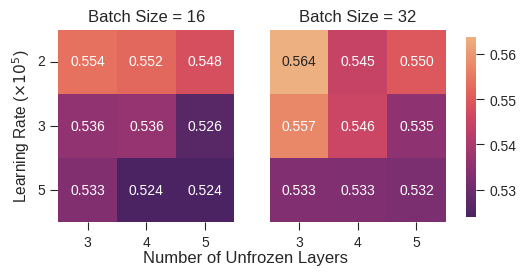

In [14]:
import seaborn as sns

# Load data into DataFrame
df = pd.read_csv('gridsearch.csv')

# Split data by batch size
df_16 = df[df['batch_size'] == 16].pivot_table(index='lr', columns='num_layers_unfrozen', values='average_f1_score')
df_32 = df[df['batch_size'] == 32].pivot_table(index='lr', columns='num_layers_unfrozen', values='average_f1_score')

# Set colorbar limits
vmin = min(df['average_f1_score'])
vmax = max(df['average_f1_score'])

# Create side-by-side heatmaps
fig, axes = plt.subplots(1, 2, figsize=(5, 2.5), sharex=True, sharey=True)
cbar_ax = fig.add_axes([0.94, 0.13, 0.02, 0.72])  # Adjust colorbar height to match heatmaps

cmap = sns.color_palette("flare_r", as_cmap=True)

# Plot heatmaps without individual colorbars
sns.heatmap(df_16, annot=True, fmt='.3f', cmap=cmap, linewidths=0, vmin=vmin, vmax=vmax, ax=axes[0], cbar=False)
axes[0].set_title("Batch Size = 16", fontsize=12)
axes[0].set_xlabel("")
axes[0].set_ylabel(f"Learning Rate ({r'$\times 10^5$'})", fontsize=11.2)

sns.heatmap(df_32, annot=True, fmt='.3f', cmap=cmap, linewidths=0, vmin=vmin, vmax=vmax, ax=axes[1], cbar=True, cbar_ax=cbar_ax)
axes[1].set_title("Batch Size = 32", fontsize=12)
axes[1].set_xlabel("")
axes[1].set_ylabel("")  # Remove y-axis label for better alignment
axes[1].tick_params(left=False)  # Remove only left tick marks

axes[0].set_yticklabels([f'{float(label.get_text()) * 1e5:.0f}' for label in axes[0].get_yticklabels()], rotation=0)

# Add a shared xlabel
fig.text(0.5, -0.05, "Number of Unfrozen Layers", ha='center', fontsize=12)

# Adjust layout and save
# plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to fit colorbar
plt.show()

[np.float64(0.5373611111111111), np.float64(0.5336555555555555), np.float64(0.53715), np.float64(0.5589722222222222), np.float64(0.5348055555555554)]
[np.float64(0.018910754453139295), np.float64(0.018668319254578052), np.float64(0.02181880597369268), np.float64(0.021455530085314364), np.float64(0.022514530529578438)]


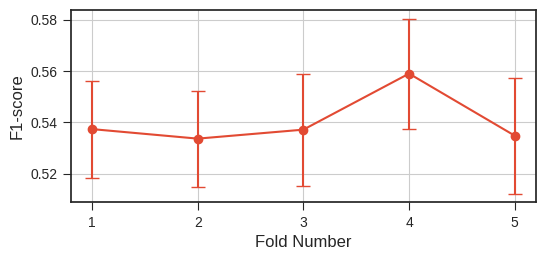

In [25]:
df = pd.read_csv('gridsearch_folds.csv')

# Compute the means and variances for each of the fold columns
means = []
variances = []
for fold in range(1, 6):
    fold_data = df[f'fold{fold}']
    means.append(fold_data.mean())
    variances.append(fold_data.std())

print(means)
print(variances)

# Plot average and variance per fold
plt.figure(figsize=(6, 2.5))
plt.errorbar(range(1, 6), means, yerr=variances, fmt='o-', label='F1-score', capsize=5)
plt.xlabel("Fold Number")
plt.ylabel("F1-score")
plt.xticks(range(1, 6))
# plt.title("Average F1-score per Fold with Standard deviation")
# plt.legend()
plt.grid(True)
plt.show()

# T5 paraphrase

In [16]:
paraphrased = pd.read_csv('train_paraphrase_upsampled.csv')
original = pd.read_csv('train_set.csv')

paraphrased['label'].value_counts()

label
0    7581
1    2242
Name: count, dtype: int64

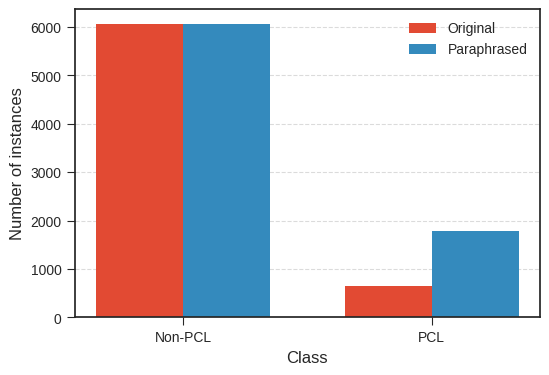

Paraphrased label counts:
label
0    6064
1    1779
Name: count, dtype: int64
Remaining validation samples in paraphrased set: 0


In [17]:
# Choose fold for train and internal validation split
fold = 1

# Load data
train = pd.read_csv(f'fold_train_{fold}.csv')
val = pd.read_csv(f'fold_val_{fold}.csv')

# Remove all labels from paraphrased that are not in the training set
paraphrased = paraphrased[paraphrased['par_id'].isin(train['par_id'].unique())]

# For class 0 and 1, plot two bars each (original and paraphrased)
plt.figure(figsize=(6, 4))
bar_width = 0.35
index = np.arange(2)

# Original data
original_counts = train['label'].value_counts()
plt.bar(index, original_counts, bar_width, label='Original')

# Paraphrased data
paraphrased_counts = paraphrased['label'].value_counts()
plt.bar(index + bar_width, paraphrased_counts, bar_width, label='Paraphrased')

plt.xlabel('Class')
plt.ylabel('Number of instances')
plt.xticks(index + bar_width / 2, ('Non-PCL', 'PCL'))
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print("Paraphrased label counts:")
print(paraphrased['label'].value_counts())

contamination_check = paraphrased[paraphrased['par_id'].isin(val['par_id'].unique())]
print(f"Remaining validation samples in paraphrased set: {len(contamination_check)}")

# Save the paraphrased training set
paraphrased.to_csv('train_paraphrase_filtered.csv', index=False)

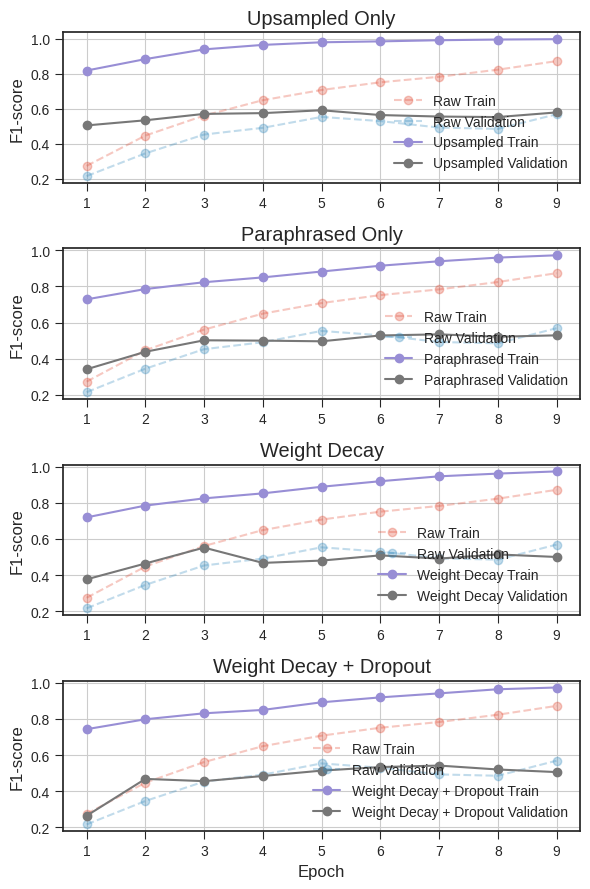

In [ ]:
"""All of the following use FOLD 1."""

# No upsampling or anything
raw_fold_train_f1_scores = [np.float64(0.2737642585551331), np.float64(0.44683136412459723), np.float64(0.5610687022900763), np.float64(0.6490299823633157), np.float64(0.7073750991276765), np.float64(0.7512864493996569), np.float64(0.7829119442022667), np.float64(0.8234280792420328), np.float64(0.8723747980613893)]
raw_fold_val_f1_scores = [np.float64(0.2153846153846154), np.float64(0.34513274336283184), np.float64(0.4528301886792453), np.float64(0.49110320284697506), np.float64(0.5534591194968553), np.float64(0.5296167247386759), np.float64(0.4925373134328358), np.float64(0.48507462686567165), np.float64(0.568561872909699)]
raw_dev_f1 = 0.599483204134367

# Upsampling to 2:3
upsampled_train_f1_scores = [np.float64(0.818511358144031), np.float64(0.8838755639990501), np.float64(0.9395525940028557), np.float64(0.9650869826034792), np.float64(0.9799684351098701), np.float64(0.9852312950079336), np.float64(0.9917801496748865), np.float64(0.9956891242763887), np.float64(0.9977783263391755)]
upsampled_val_f1_scores = [np.float64(0.5048543689320388), np.float64(0.5341880341880342), np.float64(0.5707434052757794), np.float64(0.5751295336787565), np.float64(0.5915492957746479), np.float64(0.5641025641025641), np.float64(0.5555555555555556), np.float64(0.5526315789473685), np.float64(0.5791245791245792)]
upsampled_dev_f1 = 0.5691906005221932


# Paraphrased only
paraphrase_train_f1_scores = [0.7278775781769794, 0.7847702957835117, 0.8224242424242424, 0.8490509189514914, 0.881508078994614, 0.9135305946567078, 0.9381443298969072, 0.9583571021106674, 0.9711375212224108]
paraphrase_val_f1_scores = [0.3418803418803419, 0.43846153846153846, 0.5018181818181818, 0.5, 0.4962962962962963, 0.5284280936454849, 0.5347222222222222, 0.5214285714285715, 0.5292096219931272]

# Paraphrased with weight decay 1e-2
weight_decay_train_f1_scores = [np.float64(0.7195162915686933), np.float64(0.7850173119294932), np.float64(0.8249701314217444), np.float64(0.8527459263729632), np.float64(0.8893291819983017), np.float64(0.9201824401368301), np.float64(0.9472483604220131), np.float64(0.9623931623931624), np.float64(0.9745762711864406)]
weight_decay_val_f1_scores = [np.float64(0.376), np.float64(0.463768115942029), np.float64(0.551948051948052), np.float64(0.46715328467153283), np.float64(0.48), np.float64(0.508833922261484), np.float64(0.49097472924187724), np.float64(0.5140845070422535), np.float64(0.5)]
weight_decay_dev_f1 = 0.5706806282722513

# Paraphrased with weight decay 1e-2, dropout 0.15
weight_decay_dropout_train_f1_scores = [np.float64(0.7432082794307892), np.float64(0.7983040581465778), np.float64(0.8312972658522396), np.float64(0.8499697519661222), np.float64(0.8922895821071218), np.float64(0.9196197061365601), np.float64(0.9418234442836468), np.float64(0.9646593158043539), np.float64(0.9743010449025699)]
weight_decay_dropout_val_f1_scores = [0.2634146341463415, 0.4676258992805755, 0.4552238805970149, 0.48375451263537905, 0.5135135135135135, 0.5333333333333333, 0.5415384615384615, 0.51985559566787, 0.5054945054945055]
weight_decay_dropout_dev_f1 = 0.5885416666666666


# Individual plots for paraphrased only, weight decay, and weight decay + dropout. For each plot, also plot the raw data.
fig, ax = plt.subplots(4, 1, figsize=(6, 9))

# Upsampled
ax[0].plot(range(1, 10), raw_fold_train_f1_scores, label='Raw Train', linestyle='--', marker='o', alpha=0.3)
ax[0].plot(range(1, 10), raw_fold_val_f1_scores, label='Raw Validation', linestyle='--', marker='o', alpha=0.3)
ax[0].plot(range(1, 10), upsampled_train_f1_scores, label='Upsampled Train', linestyle='-', marker='o')
ax[0].plot(range(1, 10), upsampled_val_f1_scores, label='Upsampled Validation', linestyle='-', marker='o')
ax[0].set_title("Upsampled Only")
ax[0].set_ylabel("F1-score")
ax[0].legend()
ax[0].grid(True)

# Paraphrased only
ax[1].plot(range(1, 10), raw_fold_train_f1_scores, label='Raw Train', linestyle='--', marker='o', alpha=0.3)
ax[1].plot(range(1, 10), raw_fold_val_f1_scores, label='Raw Validation', linestyle='--', marker='o', alpha=0.3)
ax[1].plot(range(1, 10), paraphrase_train_f1_scores, label='Paraphrased Train', linestyle='-', marker='o')
ax[1].plot(range(1, 10), paraphrase_val_f1_scores, label='Paraphrased Validation', linestyle='-', marker='o')
ax[1].set_title("Paraphrased Only")
ax[1].set_ylabel("F1-score")
ax[1].legend()
ax[1].grid(True)


# Weight decay
ax[2].plot(range(1, 10), raw_fold_train_f1_scores, label='Raw Train', linestyle='--', marker='o', alpha=0.3)
ax[2].plot(range(1, 10), raw_fold_val_f1_scores, label='Raw Validation', linestyle='--', marker='o', alpha=0.3)
ax[2].plot(range(1, 10), weight_decay_train_f1_scores, label='Weight Decay Train', linestyle='-', marker='o')
ax[2].plot(range(1, 10), weight_decay_val_f1_scores, label='Weight Decay Validation', linestyle='-', marker='o')
ax[2].set_title("Weight Decay")
ax[2].set_ylabel("F1-score")
ax[2].legend()
ax[2].grid(True)

# Weight decay + dropout
ax[3].plot(range(1, 10), raw_fold_train_f1_scores, label='Raw Train', linestyle='--', marker='o', alpha=0.3)
ax[3].plot(range(1, 10), raw_fold_val_f1_scores, label='Raw Validation', linestyle='--', marker='o', alpha=0.3)
ax[3].plot(range(1, 10), weight_decay_dropout_train_f1_scores, label='Weight Decay + Dropout Train', linestyle='-', marker='o')
ax[3].plot(range(1, 10), weight_decay_dropout_val_f1_scores, label='Weight Decay + Dropout Validation', linestyle='-', marker='o')
ax[3].set_title("Weight Decay + Dropout")
ax[3].set_xlabel("Epoch")
ax[3].set_ylabel("F1-score")
ax[3].legend()
ax[3].grid(True)

plt.tight_layout()
plt.show()



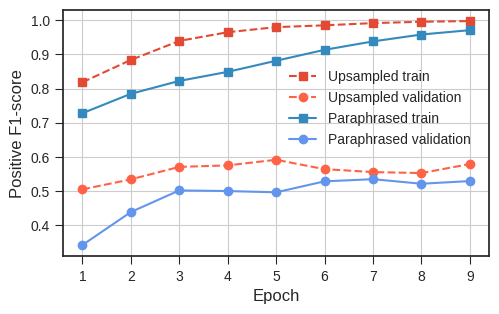

In [89]:
# Plot the train and validation F1 scores for upsampling and paraphrased only on the same plot
plt.figure(figsize=(5.5, 3.2))
# plt.plot(range(1, 10), raw_fold_train_f1_scores, label='Raw Train', linestyle='--', marker='o', alpha=0.3)
# plt.plot(range(1, 10), raw_fold_val_f1_scores, label='Raw Validation', linestyle='--', marker='o', alpha=0.3)
plt.plot(range(1, 10), upsampled_train_f1_scores, label='Upsampled train', linestyle='--', marker='s', c=colors[0])
plt.plot(range(1, 10), upsampled_val_f1_scores, label='Upsampled validation', linestyle='--', marker='o', c="tomato")
plt.plot(range(1, 10), paraphrase_train_f1_scores, label='Paraphrased train', linestyle='-', marker='s', c=colors[1])
plt.plot(range(1, 10), paraphrase_val_f1_scores, label='Paraphrased validation', linestyle='-', marker='o', c="cornflowerblue")
plt.xlabel("Epoch")
plt.ylabel("Positive F1-score")
# plt.title("Upsampled 2:3 vs T5 Paraphrased")
plt.legend(loc='center left', bbox_to_anchor=(0.5, 0.6))


plt.grid(True)
plt.show()